In [31]:
#import libraries and set the vectorBT portfolio settings

import numpy as np
import pandas as pd

np.random.seed(42)

In [32]:
import datetime as dt
# Tirei a CIEL3, pois ela não está mais sendo negociada

# ativos = pd.read_csv("./data/ativos_ibov/ativos.csv")['ativos'].to_list()
# ativos = [ativo + '.SA' for ativo in ativos]

indicadores = pd.read_csv('./data/indicadores/indicadores_final.csv', index_col='Data', parse_dates=True)['indicador']

# start = indicadores.index.min() - pd.Timedelta(365*2, 'days')
# end = indicadores.index.max()

# prices = yf.download(ativos, start=start, end=end)['Adj Close']
prices = pd.read_csv('./data/ativos_ibov/prices_adj_close.csv', index_col='Date', parse_dates=True)

prices = prices[prices.index <= dt.datetime(2023, 12, 30)]

In [33]:
limite_superior = 75
limite_inferior = 25

reotimizar = True

sinal = pd.Series(index=indicadores.index)
for data, indicador in indicadores.items():
    if (indicador > limite_superior or indicador < limite_inferior):
        if reotimizar:
            sinal.loc[data] = 1
        else:
            sinal.loc[data] = 0
        reotimizar = False
    else:
        sinal.loc[data] = 0
        reotimizar = True

indicadores_sinal = pd.concat([indicadores, sinal], axis=1)

In [34]:
# Alinhar os indicadores aos dias úteis dos preços
# Obtemos o índice (datas) do DataFrame de preços
prices_limite = prices[prices.index >= indicadores_sinal.index.min()]
business_days = prices_limite.index

# Reindexar o DataFrame de indicadores para usar apenas os dias úteis dos preços
indicadores_sinal = indicadores_sinal.reindex(business_days).ffill()

# Verificar se os índices estão agora alinhados
print(prices_limite.index.equals(indicadores_sinal.index)) # Deve retornar True se estiverem alinhados


True


In [35]:
import riskfolio as rp
import pandas as pd

# TODO: Verificar quantidade de tempo para rebalanceamento
# TODO: Constraints da otimização
def optimization(prices, data):
    # Selecionando o período de 2 anos de dados
    grupo = prices[prices.index <= data].iloc[-252*2:]

    # Calculando os retornos
    Y = grupo.pct_change().dropna()

    # Criando o portfólio
    port = rp.Portfolio(returns=Y)

    method_mu = 'hist'
    method_cov = 'ledoit'  # Usando Ledoit-Wolf shrinkage para tornar a matriz de cov positiva definida

    # Calculando as estatísticas dos ativos
    port.assets_stats(method_mu=method_mu, method_cov=method_cov)

    # Parâmetros da otimização
    model = 'Classic'
    rm = 'MV'
    obj = 'MaxRet'
    hist = True
    rf = 0
    l = 0

    # Otimizando o portfólio
    return port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

prices.sort_index(inplace=True)
indicadores_limite = indicadores_sinal.loc[indicadores_sinal[0] == 1, 0]
indicadores_limite.sort_index(inplace=True)


pesos = pd.DataFrame()
for data, entry in indicadores_limite.items():
    if entry:
        w = optimization(prices, data).T
        w.index = [data]
        pesos = pd.concat([pesos, w], axis=0)

pesos

,ABEV3.SA,ALPA4.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BEEF3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CCRO3.SA,...,TAEE11.SA,TIMS3.SA,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
2015-08-07,2.389648e-11,1.400772e-11,2.048377e-11,1.919401e-11,2.031578e-11,2.139145e-11,1.254406e-11,2.791510e-11,1.665229e-11,1.583395e-11,...,1.851527e-11,2.118553e-11,1.867728e-11,2.430283e-11,2.269965e-11,1.162815e-11,1.410461e-11,1.810867e-11,3.808663e-11,1.591293e-11
2015-08-24,3.992686e-12,2.360703e-12,3.519959e-12,3.425981e-12,3.518811e-12,3.823945e-12,1.797339e-12,4.360267e-12,2.925128e-12,3.105310e-12,...,3.275398e-12,3.510245e-12,3.182863e-12,4.235573e-12,3.991508e-12,1.601167e-12,2.069374e-12,3.157871e-12,5.383708e-12,2.955544e-12
2015-09-02,7.165922e-11,3.628314e-11,5.687759e-11,5.680405e-11,5.845641e-11,6.194804e-11,2.788686e-11,7.510661e-11,5.293270e-11,4.968792e-11,...,4.753832e-11,5.475018e-11,4.773476e-11,7.042868e-11,6.970583e-11,2.306452e-11,3.262473e-11,5.118358e-11,9.619607e-11,4.478127e-11
2015-09-22,6.465789e-12,3.529989e-12,4.435712e-12,4.816602e-12,5.022027e-12,6.136442e-12,3.059619e-12,6.077547e-12,5.166531e-12,3.927991e-12,...,5.120520e-12,4.627516e-12,4.429488e-12,7.438924e-12,6.081305e-12,2.955764e-12,3.584268e-12,4.508825e-12,8.302201e-12,4.150208e-12
2015-09-25,2.744434e-11,1.506415e-11,1.887757e-11,2.056275e-11,2.136052e-11,2.620414e-11,1.306622e-11,2.676711e-11,2.413595e-11,1.702010e-11,...,2.257807e-11,2.034993e-11,1.952632e-11,2.964517e-11,2.573974e-11,1.210199e-11,1.546400e-11,1.922742e-11,3.141552e-11,1.941489e-11
2015-09-28,2.204368e-11,1.282176e-11,1.467315e-11,1.645643e-11,1.695507e-11,2.159267e-11,1.111779e-11,2.185570e-11,1.935643e-11,1.448362e-11,...,1.886007e-11,1.694407e-11,1.640253e-11,2.328481e-11,2.094495e-11,1.075834e-11,1.279265e-11,1.632322e-11,2.459683e-11,1.634244e-11
2015-12-16,2.534338e-11,1.331181e-11,1.865573e-11,1.921927e-11,1.942842e-11,2.481257e-11,8.706413e-12,2.534099e-11,3.455313e-11,1.840581e-11,...,2.092272e-11,1.536629e-11,2.023944e-11,4.572844e-11,2.506372e-11,6.378247e-12,1.111893e-11,2.126082e-11,2.904339e-11,1.824167e-11
2016-01-18,2.359257e-11,1.530357e-11,1.536634e-11,1.744695e-11,1.772253e-11,2.292945e-11,7.229088e-12,2.290267e-11,2.952996e-11,1.629813e-11,...,2.276617e-11,1.172529e-11,1.982480e-11,2.531821e-11,2.301948e-11,5.227160e-12,9.255848e-12,1.843152e-11,2.735453e-11,1.602152e-11
2016-02-11,4.355718e-12,2.822727e-12,2.918365e-12,3.486236e-12,3.524581e-12,3.744582e-12,1.602310e-12,4.257665e-12,5.386043e-12,3.176869e-12,...,4.451514e-12,2.225982e-12,3.661971e-12,5.200046e-12,4.020748e-12,1.173005e-12,2.010571e-12,3.111258e-12,4.912686e-12,2.795819e-12
2016-04-01,5.584343e-12,3.754289e-12,6.375837e-12,6.405389e-12,6.204716e-12,5.410288e-12,2.703222e-12,5.376257e-12,7.797958e-12,4.407910e-12,...,5.675460e-12,3.627313e-12,4.120053e-12,5.689527e-12,6.187581e-12,1.937395e-12,3.293085e-12,5.157963e-12,5.528113e-12,3.116174e-12


[*********************100%%**********************]  1 of 1 completed
100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


<Axes: title={'center': 'Equity Progression'}>

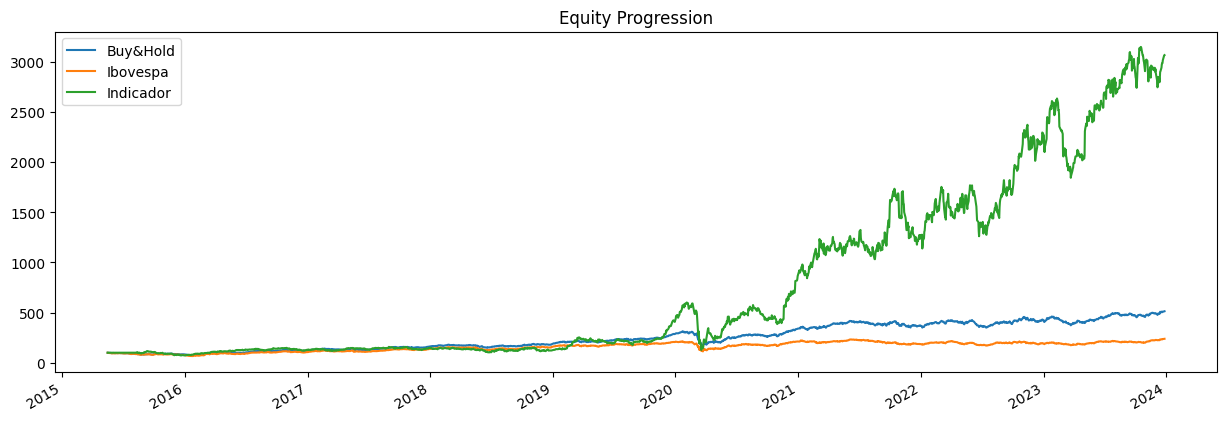

In [210]:
import bt
import yfinance as yf

prices = prices[prices.index >= indicadores.index.min()]

# Assumindo que você já tem um DataFrame 'prices' com os dados de preços de ações
# Exemplo:
# prices = yf.download(['AAPL', 'MSFT', 'GOOG'], start='2020-01-01', end='2024-01-01')['Adj Close']

# Estratégia Buy and Hold
strat_buy_hold = bt.Strategy('Buy&Hold', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Ibovespa
ibov = yf.download('^BVSP', start=prices.index.min().strftime('%Y-%m-%d'), end=prices.index.max().strftime('%Y-%m-%d'))[['Adj Close']]

# Estratégia baseada no Ibovespa (exemplo simples de benchmark)
strat_ibov = bt.Strategy('Ibovespa', [
    bt.algos.RunOnce(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

# Estratégia CVM trimestral
strat_cvm_trimestral = bt.Strategy('CVM Trimestral', [
    bt.algos.WeighTarget(pesos_trimestrais),
    bt.algos.Rebalance()
])


# Estratégia baseada no indicador
strat_indicador = bt.Strategy('Indicador CVM', [
    bt.algos.WeighTarget(pesos),
    bt.algos.Rebalance()
])
# Criando o backtest
backtests = [
    bt.Backtest(strat_cvm_trimestral, prices, initial_capital=1000000000),
    bt.Backtest(strat_ibov, ibov, initial_capital=1000000000),
    bt.Backtest(strat_indicador, prices, initial_capital=1000000000)
]

# Executando o backtest
results = bt.run(*backtests)

# Plotando os resultados
results.plot()

In [211]:
# Resultados
results.display()

Stat                 CVM Trimestral    Ibovespa    Indicador CVM
-------------------  ----------------  ----------  ---------------
Start                2015-05-17        2015-05-17  2015-05-17
End                  2023-12-27        2023-12-27  2023-12-27
Risk-free rate       0.00%             0.00%       0.00%

Total Return         413.27%     138.76%     2965.36%
Daily Sharpe         0.92        0.54        1.02
Daily Sortino        1.41        0.84        1.75
CAGR                 20.91%      10.63%      48.79%
Max Drawdown         -47.30%     -46.82%     -78.79%
Calmar Ratio         0.44        0.23        0.62

MTD                  3.99%       5.39%       4.71%
3m                   8.33%       17.38%      1.26%
6m                   16.25%      14.19%      20.68%
YTD                  19.41%      21.96%      33.77%
1Y                   22.25%      23.86%      39.89%
3Y (ann.)            15.13%      4.08%       55.34%
5Y (ann.)            23.32%      9.45%       90.38%
10Y (ann.)    

In [212]:
trans = results.get_transactions('Indicador')

KeyError: 'Indicador'

In [213]:
import pandas as pd

opt = pd.read_csv('./data/resultados_otimization.csv')

opt.drop(columns=['Unnamed: 0'], inplace=True)

In [214]:
opt2 = opt[opt['obj'] == 'MinRisk'].reset_index(drop=True)
opt2.loc[np.argmax(opt2['total_return']), ['limite_inferior', 'limite_superior', 'obj', 'total_return']]

limite_inferior         21
limite_superior         76
obj                MinRisk
total_return       6.49831
Name: 67, dtype: object

In [215]:
def calcular_precos(prices, indicadores_sinal, **kwargs):
    kwargs.setdefault('method_cov', 'ledoit')
    kwargs.setdefault('method_mu', 'hist')
    kwargs.setdefault('model', 'Classic')
    kwargs.setdefault('rm', 'MV')
    kwargs.setdefault('obj', 'MinRisk')
    kwargs.setdefault('rf', 0)
    kwargs.setdefault('l', 0)

    indicadores_limite = indicadores_sinal[indicadores_sinal == 1].sort_index()
    pesos = pd.DataFrame()

    for data, entry in indicadores_limite.items():
        if entry:
            w = optimization(prices, data, obj=kwargs['obj']).T
            w.index = [data]
            pesos = pd.concat([pesos, w], axis=0)
    return pesos

calcular_precos(prices, indicadores_sinal, obj='MaxRet')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().